# Benchmarking
Look at time vs length of trace.

In [ ]:
from datetime import timedelta
import pm4py
import time
import pandas as pd
from pm4py.objects.log.obj import EventLog

In [ ]:
sepsis = pm4py.read_xes('data/Sepsis Cases - Event Log.xes')
rtfmp = pm4py.read_xes('/home/vco/Datasets/12683249/Road_Traffic_Fine_Management_Process.xes')
bpic13i = pm4py.read_xes('/home/vco/Datasets/BPI_Challenge_2013_incidents.xes')
dreyers = pm4py.read_xes('/home/vco/Datasets/Dreyers Foundation.xes')
# dreyers does not have column of type date, but the events are ordered so create one.
dreyers['time:timestamp'] = dreyers.groupby('case:concept:name').cumcount()
dreyers['time:timestamp'] = dreyers['time:timestamp'].apply(lambda x: pd.to_datetime('2024-01-01') + timedelta(x))

In [ ]:
dfs = {'Sepsis': sepsis, 'Road traffic': rtfmp, 'BPIC13i': bpic13i, 'Dreyers': dreyers}
cmap = {'DCR': 'r', 'DECLARE': 'g', 'Log Skeleton': 'b'}

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

font = {'size'   : 22}
    # 'family' : 'normal',
    #     'weight' : 'bold',
matplotlib.rc('font', **font)

In [ ]:
conf_res = []
for k, df in dfs.items():
    train_random_10_percent, _ = pm4py.split_train_test(df,train_percentage=0.1)
    # conformance_random_50_percent, _ = pm4py.split_train_test(df,train_percentage=0.5)
    dcr_graph, _ = pm4py.discover_dcr(train_random_10_percent)
    declare_model = pm4py.discover_declare(train_random_10_percent)
    skeleton_model = pm4py.discover_log_skeleton(train_random_10_percent)
    temp_log = pm4py.convert_to_event_log(df)
    
    start_time = time.time()
    pm4py.conformance_dcr(temp_log, dcr_graph)
    elapsed_time = time.time() - start_time
    conf_res.append([elapsed_time, 'DCR', k])

    start_time = time.time()
    pm4py.conformance_declare(temp_log, declare_model)
    elapsed_time = time.time() - start_time
    conf_res.append([elapsed_time, 'DECLARE', k])

    start_time = time.time()
    pm4py.conformance_log_skeleton(temp_log, skeleton_model)
    elapsed_time = time.time() - start_time
    conf_res.append([elapsed_time, 'Log Skeleton', k])

In [ ]:
res = pd.DataFrame(conf_res,columns=['time','alg','log'])

conflogs = []
confalgs = {}
for a in res['alg'].unique():
    confalgs[a] = []
for k, v in res.groupby('log'):
    td = v['time'].to_dict()
    ad = v['alg'].to_dict()
    for a,b in td.items():
        confalgs[ad[a]].append(round(b,2))
    conflogs.append(k)
x = np.arange(len(conflogs))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(figsize=(12, 6),layout='constrained')

for attribute, measurement in confalgs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute,color=cmap[attribute])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_xlabel('Log')
ax.set_title('Rule based conformance')
ax.set_xticks(x + width, conflogs)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 6.1)

plt.show()

# Discovery

In [ ]:
# filtering in pm4py gives this warning
import warnings
warnings.filterwarnings(
    action='ignore', category=UserWarning, message=r"Boolean Series.*"
)

dis = []
for k, df in dfs.items():
    start_time = time.time()
    dcr_graph, _ = pm4py.discover_dcr(df)
    elapsed_time = time.time() - start_time
    dis.append([elapsed_time, 'DCR', k])

    start_time = time.time()
    declare_model = pm4py.discover_declare(df)
    elapsed_time = time.time() - start_time
    dis.append([elapsed_time, 'DECLARE', k])

    start_time = time.time()
    skeleton_model = pm4py.discover_log_skeleton(df)
    elapsed_time = time.time() - start_time
    dis.append([elapsed_time, 'Log Skeleton', k])

In [ ]:
res = pd.DataFrame(dis,columns=['time','alg','log'])

dislogs = []
disalgs = {}
for a in res['alg'].unique():
    disalgs[a] = []
for k, v in res.groupby('log'):
    td = v['time'].to_dict()
    ad = v['alg'].to_dict()
    for a,b in td.items():
        disalgs[ad[a]].append(round(b,2))
    dislogs.append(k)
x = np.arange(len(dislogs))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(figsize=(12, 6),layout='constrained')

for attribute, measurement in disalgs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute,color=cmap[attribute])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_xlabel('Log')
ax.set_title('Process discovery')
ax.set_xticks(x + width, dislogs)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 20)

plt.show()

# Alignment

In [ ]:
from os import listdir
from os.path import isfile, join
from pathlib import Path
log_types = ['Training Logs', 'Test Logs', 'Base Logs', 'Ground Truth Logs']
pah_to_folders = "/home/vco/Projects/axel-alignment/DCR-Alignment/data/PDC2022/"

In [ ]:
trainingDir22 = "/home/vco/Projects/axel-alignment/DCR-Alignment/data/PDC2022/Training Logs/"
testDir22 = "/home/vco/Projects/axel-alignment/DCR-Alignment/data/PDC2022/Test Logs/"
baseDir22 = "/home/vco/Projects/axel-alignment/DCR-Alignment/data/PDC2022/Base Logs/"
gtDir22 = "/home/vco/Projects/axel-alignment/DCR-Alignment/data/PDC2022/Ground Truth Logs/"

only_files = [f for f in listdir(baseDir22) if isfile(join(baseDir22, f))]

to_plot = []
for only_file in only_files:
    for i in range(5):
        train_log = pm4py.read_xes(join(pah_to_folders, log_types[0], f'{only_file[:-4]}{i}{only_file[-4:]}'))
        test_log = pm4py.read_xes(join(pah_to_folders, log_types[1], only_file))
        base_log = pm4py.read_xes(join(pah_to_folders, log_types[2], only_file))
        gt_log = pm4py.read_xes(join(pah_to_folders, log_types[3], only_file))
        train_log['time:timestamp'] = train_log.groupby('case:concept:name').cumcount()
        train_log['time:timestamp'] = train_log['time:timestamp'].apply(lambda x: pd.to_datetime('2024-01-01') + timedelta(x))
        dcr_graph, _ = pm4py.discover_dcr(train_log)
        
        start_time = time.time()
        pm4py.optimal_alignment_dcr(test_log, dcr_graph)
        pm4py.optimal_alignment_dcr(base_log, dcr_graph)
        elapsed_time = time.time() - start_time
        to_plot.append([f'{only_file[:-4]}{i}{only_file[-4:]}', elapsed_time, 'python'])

In [30]:
align_res = pd.DataFrame(to_plot,columns=['log','time','alg'])
ts_align_df = pd.read_csv('/home/vco/Projects/axel-alignment/DCR-Alignment/times.csv',sep=";")
ts_align_df['time'] = ts_align_df['time'] / 1000

In [47]:
print(align_res['time'].mean())
print(align_res['time'].std())
print(ts_align_df['time'].mean())
print(ts_align_df['time'].std())
pyts_align = pd.concat([align_res,ts_align_df])
mean_s = pyts_align.groupby('alg')['time'].mean().to_dict()
std_s = pyts_align.groupby('alg')['time'].std().to_dict()

8.674472154676915
4.520644257415169
0.7777951371354225
1.2437885025765925


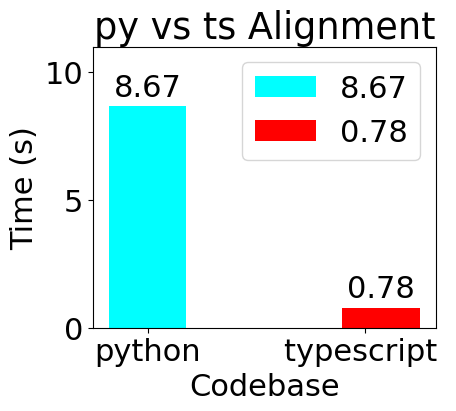

In [103]:
# pytslogs = []
# pytsalgs = {}
# for a in res['alg'].unique():
#     pytsalgs[a] = []
# for k, v in res.groupby('log'):
#     td = v['time'].to_dict()
#     ad = v['alg'].to_dict()
#     for a,b in td.items():
#         pytsalgs[ad[a]].append(round(b,2))
#     pytslogs.append(k)
# x = np.arange(len(mean_s))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(figsize=(4.5, 4),layout='constrained')
py_ts_cmap = {'python': 'cyan','typescript ':'r'}
# for attribute, measurement in mean_s.items():
offset = width * multiplier
rects = ax.bar(0.1, round(mean_s['python'],2), width, label=round(mean_s['python'],2),color=py_ts_cmap['python'])
ax.bar_label(rects, padding=3)
rects = ax.bar(0.1+width*3, round(mean_s['typescript '],2), width, label=round(mean_s['typescript '],2),color=py_ts_cmap['typescript '])
ax.bar_label(rects, padding=3)
# multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_xlabel('Codebase')
ax.set_title('py vs ts Alignment')
ax.set_xticks([0.1,0.8], mean_s)
ax.legend(loc='upper right', ncols=1)
ax.set_ylim(0, 11)

plt.show()

# Not used

# Rule based conformance checking stratified for the length of the trace

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

conf_res = []
for k, df in dfs.items():
    train_random_10_percent, _ = pm4py.split_train_test(df,train_percentage=0.1)
    # conformance_random_50_percent, _ = pm4py.split_train_test(df,train_percentage=0.5)
    dcr_graph, _ = pm4py.discover_dcr(train_random_10_percent)
    declare_model = pm4py.discover_declare(train_random_10_percent)
    skeleton_model = pm4py.discover_log_skeleton(train_random_10_percent)
    for trace in pm4py.convert_to_event_log(df):
        len_trace = len(trace)
        temp_log = EventLog()
        temp_log.append(trace)
        
        start_time = time.time()
        pm4py.conformance_dcr(temp_log, dcr_graph)
        elapsed_time = time.time() - start_time
        conf_res.append([len_trace, elapsed_time, 'dcr', k])

        start_time = time.time()
        pm4py.conformance_declare(temp_log, declare_model)
        elapsed_time = time.time() - start_time
        conf_res.append([len_trace, elapsed_time, 'declare', k])

        start_time = time.time()
        pm4py.conformance_log_skeleton(temp_log, skeleton_model)
        elapsed_time = time.time() - start_time
        conf_res.append([len_trace, elapsed_time, 'skeleton', k])
res = pd.DataFrame(conf_res,columns=['length','time','alg','log'])

logs = []
algs = {}
for a in res['alg'].unique():
    algs[a] = []
for k, v in res.groupby('log'):
    td = v['time'].to_dict()
    ad = v['alg'].to_dict()
    for a,b in td.items():
        algs[ad[a]].append(round(b,2))
    logs.append(k)

x = np.arange(len(logs))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in algs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_xlabel('Log')
ax.set_title('Rule based conformance checking in pm4py')
ax.set_xticks(x + width, logs)
ax.legend(loc='upper left', ncols=1)
# ax.set_ylim(0, 6)

plt.show()

# Discovery stratified for short to log traces in the log

In [ ]:
# filtering in pm4py gives this warning
import warnings
warnings.filterwarnings(
    action='ignore', category=UserWarning, message=r"Boolean Series.*"
)

def ranges(min_trace, max_trace):
    step = (max_trace - min_trace)/10
    res = [int(x*step) for x in range(10)]
    if min_trace < step:
        res[0] = min_trace
    if max_trace > 10*step:
        res.append(max_trace)
    return res

dis = {}
for k, df in dfs.items():
    min_trace = int(df[['case:concept:name','concept:name']].groupby('case:concept:name').count().min().iloc[0])
    max_trace = int(df[['case:concept:name','concept:name']].groupby('case:concept:name').count().max().iloc[0])
    splits = ranges(min_trace, max_trace)
    min_size = splits[0]
    to_plot = []
    i = 0
    for max_size in splits[1:]:
        subset_df = pm4py.filter_case_size(df, min_size=min_size, max_size=max_size)
        if len(subset_df)>0:
            start_time = time.time()
            dcr_graph, _ = pm4py.discover_dcr(subset_df)
            elapsed_time = time.time() - start_time
            to_plot.append([i, elapsed_time, 'dcr'])
        
            start_time = time.time()
            declare_model = pm4py.discover_declare(subset_df)
            elapsed_time = time.time() - start_time
            to_plot.append([i, elapsed_time, 'declare'])
        
            start_time = time.time()
            skeleton_model = pm4py.discover_log_skeleton(subset_df)
            elapsed_time = time.time() - start_time
            to_plot.append([i, elapsed_time, 'skeleton'])
        i+=10
        min_size = max_size
    dis[k] = pd.DataFrame(to_plot)

# Discovery stratified as percentages of the log

In [ ]:
# filtering in pm4py gives this warning
import warnings
warnings.filterwarnings(
    action='ignore', category=UserWarning, message=r"Boolean Series.*"
)

log_percent = [x / 10 for x in range(1, 11, 1)]
dis = []
for k, df in dfs.items():
    for lp in log_percent:
        subset_df, _ = pm4py.split_train_test(df,train_percentage=lp)
        if len(subset_df)>0:
            start_time = time.time()
            dcr_graph, _ = pm4py.discover_dcr(subset_df)
            elapsed_time = time.time() - start_time
            dis.append([lp, elapsed_time, 'dcr', k])
        
            start_time = time.time()
            declare_model = pm4py.discover_declare(subset_df)
            elapsed_time = time.time() - start_time
            dis.append([lp, elapsed_time, 'declare', k])
        
            start_time = time.time()
            skeleton_model = pm4py.discover_log_skeleton(subset_df)
            elapsed_time = time.time() - start_time
            dis.append([lp, elapsed_time, 'skeleton', k])
res_detail = pd.DataFrame(dis,columns=['percent','time','alg','log'])